In [1]:
import re

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from utils import calc_metrics

num_columns = ['inflation', 'rate', 'usd', 'usd_cur_change_relative']

In [2]:
X = pd.read_csv('data/x.csv', index_col='date')
y = pd.read_csv('data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

scaler = StandardScaler()
scaler.fit(X[num_columns])
X[num_columns] = scaler.transform(X[num_columns])

### Tf-idf и линейная модель

Протестируем TF-IDF на текстах релизов.

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS])
    return text

vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [4]:
auc = []
for c in tqdm(np.linspace(0.001, 10, 30)):
    auc.append(calc_metrics(
        tf_idf, y,
        LogisticRegression, 
        name='tf-idf l1 only release', 
        plot=False, 
        solver='liblinear', 
        penalty='l1', 
        C=c.item())
        )

roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  3%|▎         | 1/30 [00:00<00:03,  7.50it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  7%|▋         | 2/30 [00:00<00:04,  6.53it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined a

Лучшая модель - LogisticRegression(C=10.0, penalty='l1', solver='liblinear')
ROC-AUC = 0.7841821034208433


              precision    recall  f1-score   support

        -1.0       0.70      0.70      0.70        23
         0.0       0.47      0.58      0.52        24
         1.0       0.77      0.53      0.62        19

    accuracy                           0.61        66
   macro avg       0.64      0.60      0.61        66
weighted avg       0.63      0.61      0.61        66



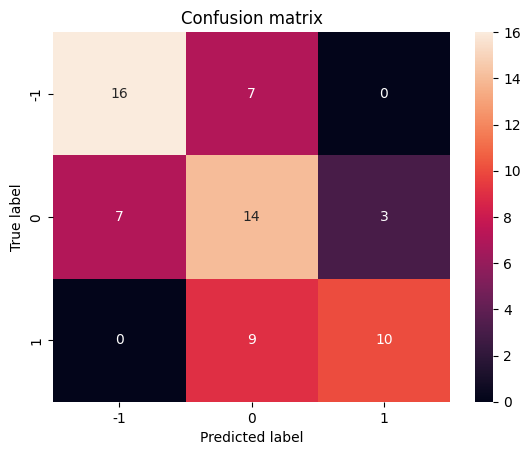

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [5]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf l1 only release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Слова при которых коэффициент равен нулю, будем считать стоп-словами? сохраним их в `stopwords.txt`.

In [6]:
words = vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)]
with open('stopwords.txt', 'wt', encoding='utf-8') as file:
    file.writelines(s + '\n' for s in words)

In [7]:
STOP_WORDS |= set(vectorizer.get_feature_names_out()[np.all(model.coef_ == 0, axis=0)])

In [8]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer.fit(X.release)

tf_idf = vectorizer.transform(X.release)

In [9]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                tf_idf, y,
                LogisticRegression,
                name='tf-idf', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                l1_ratio=l1_ratio
                )
            )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.9009376235637223


              precision    recall  f1-score   support

        -1.0       0.82      0.78      0.80        23
         0.0       0.67      0.75      0.71        24
         1.0       0.82      0.74      0.78        19

    accuracy                           0.76        66
   macro avg       0.77      0.76      0.76        66
weighted avg       0.76      0.76      0.76        66



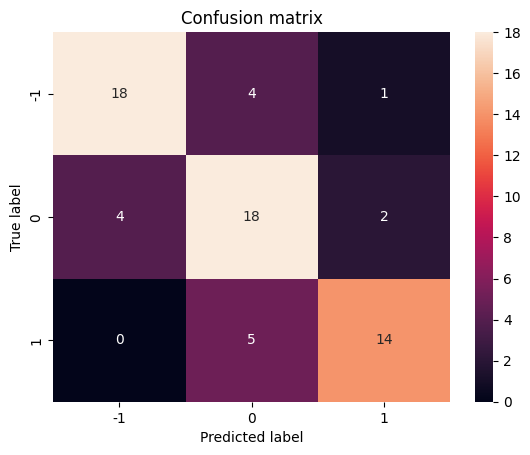

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [10]:
metric, model = calc_metrics(
    tf_idf, y, 
    LogisticRegression, 
    name='tf_idf only release best word', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

Качество еще немного подросло. Как и в случае с мешком слов попробуем обучить tf-idf на названиях и добавим эти переменые в матрицу объект-признак.

In [11]:
vectorizer_title = TfidfVectorizer(
    preprocessor=preprocessor,
)

vectorizer_title.fit(X.title)

tf_idf_title = vectorizer_title.transform(X.title)

In [12]:
tf_idf_title_release = np.concatenate((tf_idf.toarray(), tf_idf_title.toarray()), axis=1)

In [13]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                tf_idf_title_release, y,
                LogisticRegression,
                name='tf-idf', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8787469513247727


              precision    recall  f1-score   support

        -1.0       0.80      0.70      0.74        23
         0.0       0.60      0.75      0.67        24
         1.0       0.81      0.68      0.74        19

    accuracy                           0.71        66
   macro avg       0.74      0.71      0.72        66
weighted avg       0.73      0.71      0.72        66



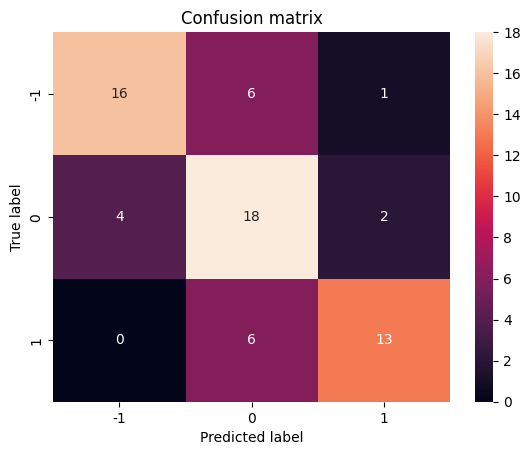

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [14]:
metric, model = calc_metrics(
    tf_idf_title_release, y, 
    LogisticRegression, 
    name='tf_idf title release', 
    **best_model.get_params()
    )
metrics = pd.concat([metrics, metric], axis=0)
metrics

При добавлении названия, качество модели заметно ухудшается, возможно эти признаки приводят к переобучению. Попробуем добавить количественные переменные.

In [15]:
tf_idf_num = np.concatenate((tf_idf.toarray(), X[num_columns].values), axis=1)

In [16]:
auc = []
for c in tqdm([0.1, 1, 5, 10]):
    for l1_ratio in [0.1, 0.5, 0.9]:
        auc.append(
            calc_metrics(
                tf_idf_num, y,
                LogisticRegression,
                name='tf-idf', 
                plot=False, 
                solver='saga', 
                penalty='elasticnet', 
                C=c, 
                max_iter=10000, 
                l1_ratio=l1_ratio
            )
        )
    
roc_auc, best_model = max(auc)

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Лучшая модель - LogisticRegression(C=10, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
ROC-AUC = 0.8358718748504713


              precision    recall  f1-score   support

        -1.0       0.78      0.61      0.68        23
         0.0       0.56      0.79      0.66        24
         1.0       0.86      0.63      0.73        19

    accuracy                           0.68        66
   macro avg       0.73      0.68      0.69        66
weighted avg       0.72      0.68      0.69        66



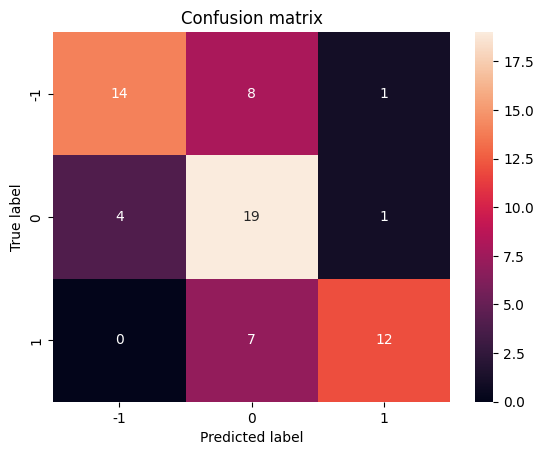

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [17]:
metric, model = calc_metrics(
    tf_idf_num, y,
    LogisticRegression,
    name='tf_idf numerical release', 
    **best_model.get_params()
)
metrics = pd.concat([metrics, metric], axis=0)
metrics

Добавление цифр из наших данных только ухудшило нашу модель. Попробуем обучить SVC, на tf-idf матрице лучших слов.

In [18]:
auc = []
for c in tqdm([0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10]):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        auc.append(
            calc_metrics(
                tf_idf, y,
                SVC,
                name='bow svc only release', 
                kernel=kernel,
                C=c,
                plot=False, 
                probability=True,
                )
            )
    
roc_auc, best_model = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\Desktop\cbr-press-release-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Лучшая модель - SVC(C=5, kernel='linear', probability=True)
ROC-AUC = 0.9296832306104513


              precision    recall  f1-score   support

        -1.0       0.78      0.78      0.78        23
         0.0       0.66      0.79      0.72        24
         1.0       0.93      0.68      0.79        19

    accuracy                           0.76        66
   macro avg       0.79      0.75      0.76        66
weighted avg       0.78      0.76      0.76        66



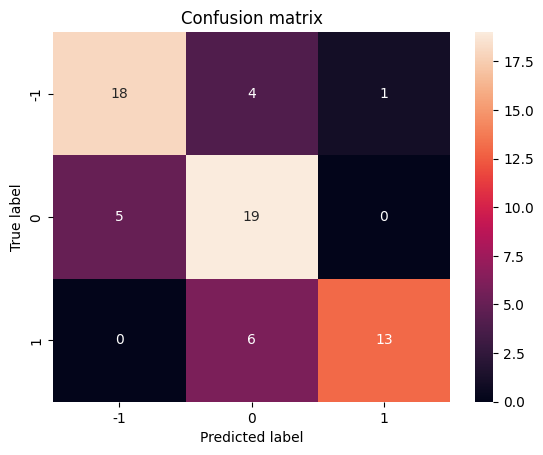

,accuracy,f1,precision,recall,roc_auc_ovr
min_baseline,0.663158,0.667893,0.669919,0.666111,NaN
bow l1 only release,0.621212,0.627058,0.642995,0.619311,0.769110
bow elasticnet,0.681818,0.686510,0.705556,0.678521,0.861207
bow release title,0.681818,0.686510,0.705556,0.678521,0.861207
bow release all num,0.696970,0.698591,0.708400,0.693618,0.858634
bow svc only release,0.666667,0.676367,0.695838,0.667684,0.836664
tf_idf l1 only release,0.606061,0.613057,0.643850,0.601767,0.784513
tf_idf only release best word,0.757576,0.761220,0.769459,0.756484,0.901979
tf_idf title release,0.712121,0.717903,0.737500,0.709954,0.878747
tf_idf numerical release,0.681818,0.688457,0.731248,0.677314,0.835872


In [19]:
metric, _ = calc_metrics(
    tf_idf, y, 
    SVC, 
    name='tf-idf svc only release', 
    **best_model.get_params()
    )

metrics = pd.concat([metrics, metric])
metrics

Мы еще немного улучшились.

In [20]:
metrics.to_csv('metrics.csv')